In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft
from scipy import interpolate
from os.path import dirname, join as pjoin
import scipy.io as sio

In [2]:
def classical_periodogram(t,val,f):
    N = len(t)
    return (1/N)* np.abs(np.sum(val*np.exp(-2j*math.pi*f*t)))**2

In [3]:
#lomb Scargle
def ls_periodogram(t,val,f):
    if f == 0:
        return np.mean(val)
    else:
    
        tau_temp = (4 * np.pi * f) * np.arctan2(np.sum(np.sin(4 * np.pi * f * t)),
                                               np.sum(np.cos(4 * np.pi * f * t)))
        tau = 1./tau_temp if tau_temp != 0 else 0

        A_2 = 1/np.sum(np.cos(2 * np.pi * f * (t - tau)) ** 2) 
        B_2 = 1/np.sum(np.sin(2 * np.pi * f * (t - tau)) ** 2)

        cos_part = np.sum(val*np.cos(2 * np.pi * f * (t - tau)))**2
        sin_part = np.sum(val*np.sin(2 * np.pi * f * (t - tau)))**2

        ls = (A_2/2)* cos_part + (B_2/2)* sin_part
        return ls


In [4]:
#generate evenly and unevenly sampled data
T = 10
fs = 100
t = np.linspace(0,10,T * fs)
f = 10
noise_power = 0.01 * fs / 2
drop_rate = 0.5
n_samples = int(len(t)*(1-drop_rate))
y = np.zeros(t.shape)

#generate harmonic sinusoid
for harmonic in [1,2,3,4]:
    y += np.sin(2*math.pi*f*harmonic*t)

#add noise
y += np.random.normal(scale=np.sqrt(noise_power), size=t.shape)


#remove random samples to create unevenly sampled data
rnd_indices = np.random.permutation(range(1,len(t)-1))
rnd_indices = np.sort(rnd_indices[0:n_samples-2])
rnd_indices = np.concatenate([[0],rnd_indices,[len(t)-1]])
y_uneven = y[rnd_indices]
t_uneven = t[rnd_indices]

#interpolate unevenly sampled data
f = interpolate.interp1d(t_uneven,y_uneven,kind ='cubic')
y_interpol = f(t)

#periodogram on evenly sampled and interpolated data
freq_even,P_even = signal.periodogram(y,fs)
freq_interpol,P_interpol = signal.periodogram(y_interpol,fs)

#periodogram on unevenly sampled data
frequencies_sin = np.linspace(0,fs/2,500)
P_uneven_sin = [classical_periodogram(t_uneven,y_uneven,f) for f in frequencies_sin]


#Lomb-Scargle Periodogram on uneven data

P_ls_uneven_sin = [ls_periodogram(t_uneven,y_uneven,f) for f in frequencies_sin]

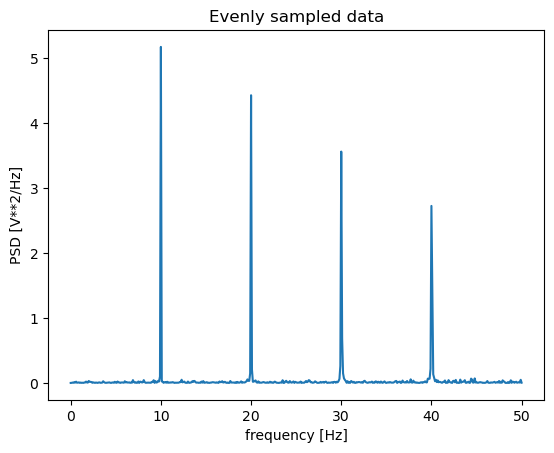

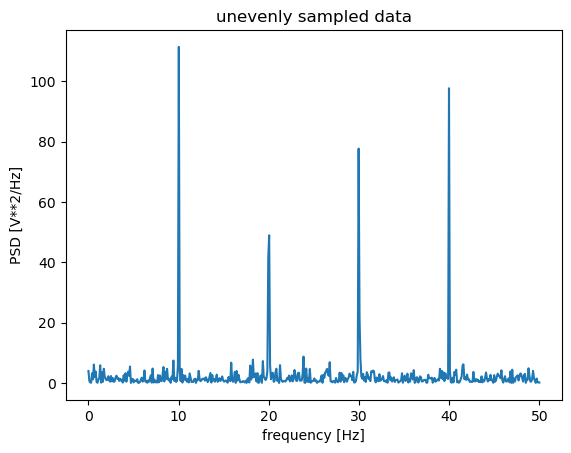

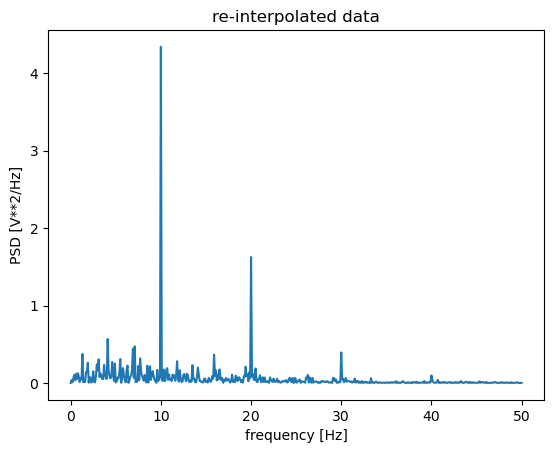

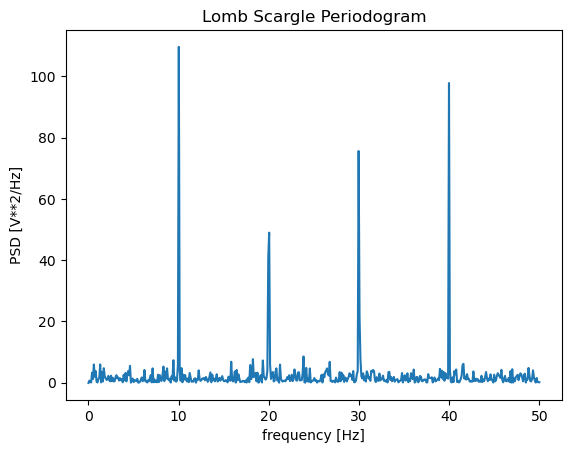

In [5]:
#plots for generated data

plt.plot(freq_even, P_even)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Evenly sampled data')
plt.savefig('even_sin.jpg')
plt.show()


plt.plot(frequencies_sin, P_uneven_sin)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('unevenly sampled data')
plt.savefig('uneven_sin.jpg')
plt.show()

plt.plot(freq_interpol, P_interpol)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('re-interpolated data')
plt.savefig('interpol_sin.jpg')
plt.show()
#plt.plot(np.abs(fft(y)))

plt.plot(frequencies_sin, P_ls_uneven_sin)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Lomb Scargle Periodogram')
plt.savefig('ls_sin.jpg')
plt.show()

In [6]:
#analyse ECG

#extract signal from mat
rr_name = "rrSignal.mat"
rr_mat = sio.loadmat(rr_name)
rr_signal = rr_mat["rrSignal"]

ecg_name = "ecgFiltered.mat"
ecg_mat = sio.loadmat(ecg_name)
ecg_signal = ecg_mat["ecg"]

ecg_wave = ecg_signal[:,1]
ecg_time = ecg_signal[:,0]

ecg_fs = np.round(len(ecg_time)/(ecg_time[len(ecg_time)-1])).astype(int)

#ecg_time = ecg_time/ecg_fs
#take 5 seconds of ecg
T = 5
ecg_wave = ecg_wave[0:T*ecg_fs]
ecg_time = ecg_time[0:T*ecg_fs]

frequencies_ecg = np.linspace(0,50,1000)

#compute periodogram


P_ecg_even = [classical_periodogram(ecg_time,ecg_wave,f) for f in frequencies_ecg]



#drop samples
drop_rate = 0.9
n_samples = int(len(ecg_time)*(1-drop_rate))
rnd_indices = np.random.permutation(range(1,len(ecg_time)-1))
rnd_indices = np.sort(rnd_indices[0:n_samples-2])
rnd_indices = np.concatenate([[0],rnd_indices,[len(ecg_time)-1]])

ecg_wave_uneven = ecg_wave[rnd_indices]
ecg_time_uneven = ecg_time[rnd_indices]

#compute periodogram for unevenly sampled data

P_ecg_uneven = [classical_periodogram(ecg_time_uneven,ecg_wave_uneven,f) for f in frequencies_ecg]

#interpolate
f_ecg = interpolate.interp1d(ecg_time_uneven,ecg_wave_uneven,kind ='cubic')
ecg_wave_interpol = f_ecg(ecg_time)

ecg_frequencies_inter,P_ecg_inter = signal.periodogram(ecg_wave_interpol,ecg_fs)
P_ecg_inter = np.abs(P_ecg_inter)
P_ecg_inter = [classical_periodogram(ecg_time,ecg_wave_interpol,f) for f in frequencies_ecg]

#Lomb-Scargle Periodogram on uneven ECG
P_ecg_ls = [ls_periodogram(ecg_time_uneven,ecg_wave_uneven,f) for f in frequencies_ecg]

FileNotFoundError: [Errno 2] No such file or directory: 'rrSignal.mat'

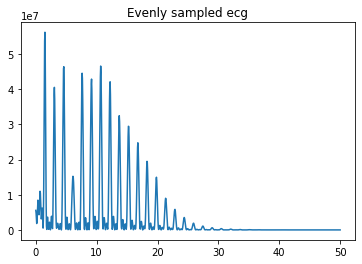

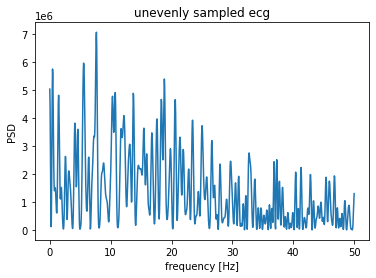

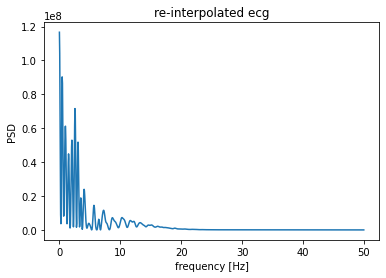

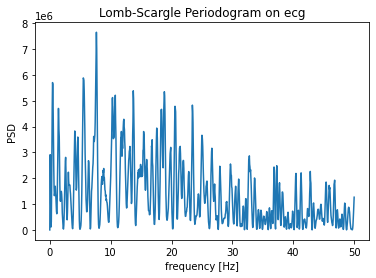

In [24]:

plt.plot(frequencies_ecg,P_ecg_even)
plt.title('Evenly sampled ecg')
plt.savefig('even_ecg.jpg')
plt.show()

plt.figure()
plt.plot(frequencies_ecg, P_ecg_uneven)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('PSD')
plt.title('unevenly sampled ecg')
plt.savefig('uneven_ecg.jpg')
plt.show()

plt.figure()
plt.plot(frequencies_ecg, P_ecg_inter)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('PSD')
plt.title('re-interpolated ecg')
plt.savefig('interpol_ecg.jpg')
plt.show()



plt.figure()
plt.plot(frequencies_ecg, P_ecg_ls)
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('PSD')
plt.title('Lomb-Scargle Periodogram on ecg')
plt.savefig('ls_ecg.jpg')
plt.show()



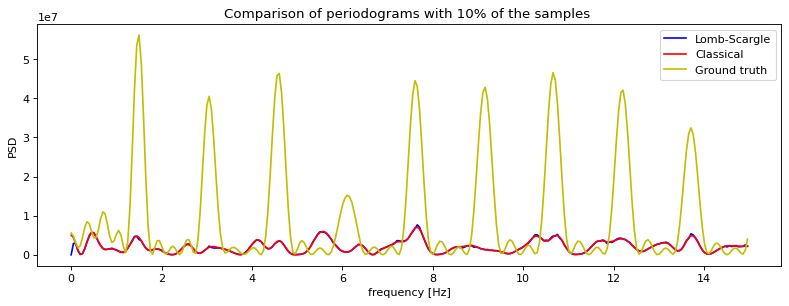

In [25]:
#compare periodograms

plt.figure(figsize=(12, 4), dpi=80)
plt.plot(frequencies_ecg[0:300], P_ecg_ls[0:300],'b',label = 'Lomb-Scargle')
plt.plot(frequencies_ecg[0:300],P_ecg_uneven[0:300],'r',label = 'Classical')
plt.plot(frequencies_ecg[0:300],P_ecg_even[0:300],'y',label = 'Ground truth')
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('PSD')
plt.legend()
plt.title('Comparison of periodograms with 10% of the samples ')
plt.savefig('comparison_10.jpg')
plt.show()



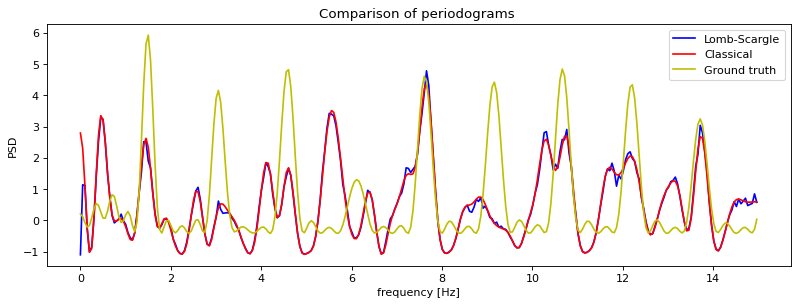

In [26]:
#compare periodograms normalized

P_ecg_ls_norm = (P_ecg_ls - np.mean(P_ecg_ls))/np.std(P_ecg_ls)
P_ecg_uneven_norm = (P_ecg_uneven - np.mean(P_ecg_uneven))/np.std(P_ecg_uneven)
P_ecg_even_norm = (P_ecg_even - np.mean(P_ecg_even))/np.std(P_ecg_even)

plt.figure(figsize=(12, 4), dpi=80)
plt.plot(frequencies_ecg[0:300], P_ecg_ls_norm[0:300],'b',label = 'Lomb-Scargle')
plt.plot(frequencies_ecg[0:300],P_ecg_uneven_norm[0:300],'r',label = 'Classical')
plt.plot(frequencies_ecg[0:300],P_ecg_even_norm[0:300],'y',label = 'Ground truth')
#plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('PSD')
plt.legend()
plt.title('Comparison of periodograms ')
plt.savefig('comparison.jpg')
plt.show()